In [1]:

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
import scipy.io as sio


In [2]:
# Load the tensorflow data
with open("data/tensorflow_depth_training_time.pkl", "rb") as f:
    experiment = pickle.load(f)
tf_depth_results = experiment["Results"]
with open("data/tensorflow_width_training_time.pkl", "rb") as f:
    experiment = pickle.load(f)
tf_width_results = experiment["Time Measurements"]

# Load the matlab data
matlab_results = sio.loadmat('data/results_depth.mat')
matlab_depth_results = matlab_results['results']
matlab_results = sio.loadmat('data/results_width.mat')
matlab_width_results = matlab_results['results']

def concat_results_to_dataframe(tf_results, matlab_results, variable_name="Layers"):
    tf_df = results_to_dataframe(tf_results, variable_name=variable_name)
    matlab_df = results_to_dataframe(matlab_results, variable_name=variable_name, matlab_results=True)
    t_df = tf_df[["Model", variable_name, "Mean"]]
    t_df.loc[:, "Model"] = t_df.loc[:,"Model"].apply(lambda x: x + " tf")
    m_df = matlab_df[['Model', variable_name, 'Mean']]
    m_df.loc[:, "Model"] = m_df.loc[:,"Model"].apply(lambda x: x + " matlab")
    return pd.concat([t_df, m_df])

df_depth = concat_results_to_dataframe(tf_depth_results, matlab_depth_results, variable_name="Layers")
df_width = concat_results_to_dataframe(tf_width_results, matlab_width_results, variable_name="Units")

In [14]:
df_depth
pivot_df = df_depth.pivot(index='Model', columns='Layers', values='Mean').reset_index()
pivot_df.columns.name = None 
pivot_df.columns = ['Model', 'Layer1', 'Layer2', 'Layer4']
pivot_df.reset_index(drop=True, inplace=True)
pivot_df[['Network', 'Framework']] = pivot_df['Model'].str.rsplit(' ', n=1, expand=True)
for layer in ['Layer1', 'Layer2', 'Layer4']:
    pivot_df[f'Speedup_{layer}'] = pivot_df.apply(lambda row: pivot_df[(pivot_df['Network'] == row['Network']) & (pivot_df['Framework'] != row['Framework'])][layer].values[0] / row[layer]  , axis=1)

pivot_df

,Model,Layer1,Layer2,Layer4,Network,Framework,Speedup_Layer1,Speedup_Layer2,Speedup_Layer4
0,GRU matlab,6.512855,12.970484,24.427052,GRU,matlab,0.768407,0.722680,0.745269
1,GRU tf,5.004522,9.373514,18.204715,GRU,tf,1.301394,1.383738,1.341798
2,LSTM matlab,4.967271,8.218829,15.789666,LSTM,matlab,0.980353,1.105146,1.110914
3,LSTM tf,4.869677,9.083008,17.540956,LSTM,tf,1.020041,0.904858,0.900160
4,LSTM with peepholes matlab,43.192326,93.994291,198.107195,LSTM with peepholes,matlab,0.140650,0.119193,0.109173
5,LSTM with peepholes tf,6.074982,11.203489,21.628020,LSTM with peepholes,tf,7.109869,8.389734,9.159747
6,Residual LSTM matlab,48.379693,102.943136,214.589235,Residual LSTM,matlab,0.088466,0.079293,0.074427
7,Residual LSTM tf,4.279939,8.162705,15.971230,Residual LSTM,tf,11.303829,12.611400,13.435987


In [18]:
df_width["Units"].unique()

array([ 10,  20,  50, 100, 200, 400], dtype=int64)

In [20]:
# TODO
df_width
pivot_df = df_width.pivot(index='Model', columns='Units', values='Mean').reset_index()
pivot_df.columns.name = None 
u_columns = ['U10', 'U20', 'U50', 'U100', 'U200', 'U400']
pivot_df.columns = ['Model'] + u_columns
pivot_df.reset_index(drop=True, inplace=True)
pivot_df[['Network', 'Framework']] = pivot_df['Model'].str.rsplit(' ', n=1, expand=True)
for layer in u_columns:
    pivot_df[f'Speedup_{layer}'] = pivot_df.apply(lambda row: pivot_df[(pivot_df['Network'] == row['Network']) & (pivot_df['Framework'] != row['Framework'])][layer].values[0] / row[layer]  , axis=1)

pivot_df

,Model,U10,U20,U50,U100,U200,U400,Network,Framework,Speedup_U10,Speedup_U20,Speedup_U50,Speedup_U100,Speedup_U200,Speedup_U400
0,GRU matlab,8.574827,6.953889,9.805423,10.756273,15.148419,41.407655,GRU,matlab,0.556900,0.703403,0.516062,0.685964,0.756979,0.847654
1,GRU tf,4.775321,4.891387,5.060202,7.378417,11.467035,35.099373,GRU,tf,1.795654,1.421660,1.937753,1.457802,1.321041,1.179726
2,LSTM matlab,6.220239,4.617453,5.754540,10.392283,14.382378,56.011408,LSTM,matlab,0.774784,1.010978,0.908806,0.728462,0.818977,0.771557
3,LSTM tf,4.819340,4.668145,5.229761,7.570380,11.778842,43.215985,LSTM,tf,1.290683,0.989141,1.100345,1.372756,1.221035,1.296081
4,LSTM with peepholes matlab,43.428760,50.249684,84.852089,118.452611,185.535487,344.897119,LSTM with peepholes,matlab,0.126547,0.113922,0.076755,0.077775,0.074339,0.126449
5,LSTM with peepholes tf,5.495771,5.724526,6.512836,9.212704,13.792571,43.611777,LSTM with peepholes,tf,7.902214,8.777964,13.028439,12.857530,13.451842,7.908348
6,Residual LSTM matlab,47.442980,54.856053,87.319232,123.211234,199.199244,358.758934,Residual LSTM,matlab,0.078958,0.077165,0.053302,0.057873,0.059445,0.117225
7,Residual LSTM tf,3.746004,4.232972,4.654322,7.130657,11.841431,42.055438,Residual LSTM,tf,12.664958,12.959229,18.760894,17.279086,16.822227,8.530619


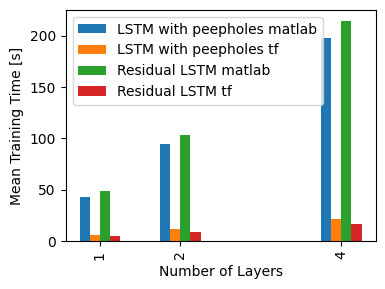

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


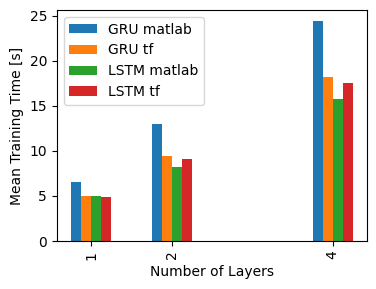

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


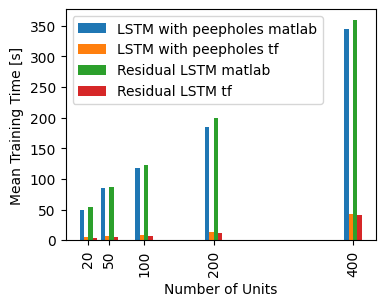

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


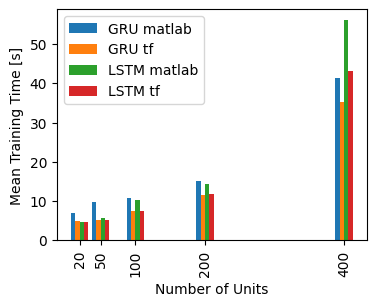

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


UnboundLocalError: local variable 'save_path_custom' referenced before assignment

In [4]:

def plot_matlab_tf_comparison(df, variable_name="Layers", use_bars=True, bar_width=1.0, xlabel="Number of Units", save_path=None, figsize=(8,4), title=None):
    res_peep_df = df.where(df["Model"].str.contains("Residual") | df["Model"].str.contains("peepholes")).dropna()
    if save_path:
        save_path_custom = save_path+"_custom.eps"
    plot_training_time(res_peep_df, variable_name, use_bars=use_bars, bar_width=bar_width, xlabel=xlabel, save_path=save_path_custom, figsize=figsize, title=title)
    vanila_gru_lstm_df = df.where(~df["Model"].str.contains("Residual") & ~df["Model"].str.contains("peepholes")).dropna()

    if save_path:
        save_path_default = save_path+"_default.eps"

    plot_training_time(vanila_gru_lstm_df, variable_name, use_bars=use_bars, bar_width=bar_width, xlabel=xlabel, save_path=save_path_default, figsize=figsize, title=title)

plot_matlab_tf_comparison(
    df_depth, variable_name="Layers", use_bars=True, bar_width=0.5, xlabel="Number of Layers", save_path="C:\\Users\\janma\\Programovani\\diplomova_prace\\LSTM-crystal-growth\\text\\img\\train_time_comparison_depth", figsize=(4,3))

df_width_no_10 = df_width[df_width["Units"] != 10]
plot_matlab_tf_comparison(df_width_no_10, variable_name="Units", use_bars=True, bar_width=25.0, save_path="C:\\Users\\janma\\Programovani\\diplomova_prace\\LSTM-crystal-growth\\text\\img\\train_time_comparison_width", figsize=(4,3))

plot_matlab_tf_comparison(df_depth, variable_name="Layers", use_bars=False, bar_width=0.5, xlabel="Number of Layers", save_path=None)

df_width_no_10 = df_width[df_width["Units"] != 10]
plot_matlab_tf_comparison(df_width_no_10, variable_name="Units", use_bars=False, bar_width=25.0, save_path=None)